In [16]:
from dotenv import load_dotenv
load_dotenv()
import os


from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003774581, 'queue_time': 0.095855573, 'total_time': 0.053774581}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-70f4d848-ff6d-4ee6-98e4-d5b437c6c010-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [17]:
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import add_messages
from typing import Annotated, List, Dict, Any


class BlogState(TypedDict):
    topic: str
    title: str
    search_results: List[Dict[str, Any]]
    blog_content: Annotated[List, add_messages]
    reviewed_content: Annotated[List, add_messages]
    is_blog_ready: str

In [18]:
from langdetect import detect

# Helper function to detect English language
def is_english(text):
    # Ensure we have enough text to analyze
    if not text or len(text.strip()) < 50:
        return False
        
    try:
        # Try primary language detection
        return detect(text) == 'en'
    except:
        # If detection fails, use a more robust approach
        common_english_words = ['the', 'and', 'in', 'to', 'of', 'is', 'for', 'with', 'on', 'that', 
                              'this', 'are', 'was', 'be', 'have', 'it', 'not', 'they', 'by', 'from']
        text_lower = text.lower()
        # Count occurrences of common English words
        english_word_count = sum(1 for word in common_english_words if f" {word} " in f" {text_lower} ")
        # Calculate ratio of English words to text length
        text_words = len(text_lower.split())
        if text_words == 0:  # Avoid division by zero
            return False
            
        english_ratio = english_word_count / min(20, text_words)  # Cap at 20 to avoid skew
        return english_word_count >= 5 or english_ratio > 0.25  # More stringent criteria

In [19]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from datetime import datetime

def generate_title(state: BlogState):
    prompt = f"""Generate compelling blog title option about {state["topic"]} that is:
    - SEO-friendly
    - Attention-grabbing
    - Topic-agnostic (works for multiple niches)
    - Between 6-12 words
    """
    
    response = llm.invoke(prompt)
    return {"title": response.content}

def search_web(state: BlogState):
    
    search_tool = TavilySearchResults(max_results=2)
    
    # Create search query with date to get recent news
    query = f"Latest data on {state["topic"]}"
    
    # Execute search
    search_results = search_tool.invoke({"query": query})
    
    # Filter out YouTube results and non-English content
    filtered_results = []
    for result in search_results:
        if "youtube.com" not in result.get("url", "").lower():
            # Check if content is in English
            content = result.get("content", "") + " " + result.get("title", "")
            if is_english(content):
                filtered_results.append(result)
    
    return {"search_results": filtered_results}

def generate_content(state: BlogState):
    prompt = f"""Write a comprehensive blog post titled "{state["title"]}" and based on the web search results {state["search_results"]} with:
    1. Engaging introduction with hook
    2. 3-5 subheadings with detailed content
    3. Practical examples/statistics
    4. Clear transitions between sections
    5. Actionable conclusion
    Style: Professional yet conversational (Flesch-Kincaid 60-70). Use markdown formatting
    """
    
    response = llm.invoke(prompt)
    return {"blog_content": response.content}

def review_content(state: BlogState):
    prompt = f"""Critically review this blog content (scale 1-10):
    - Clarity & Structure
    - Grammar & Style
    - SEO optimization
    - Reader engagement
    Provide specific improvement suggestions. Content:\n{state["blog_content"]}"""
    
    feedback = llm.invoke(prompt)
    
    return {"reviewed_content": feedback.content}

def evaluate_content(state: BlogState):

    # Create evaluation prompt
    prompt = f"""Evaluate blog content against editorial feedback (Pass/Fail):
    
    Original Blog Content:
    {state["blog_content"]}

    Editor Feedback:
    {state["reviewed_content"]}

    Evaluation Criteria:
    1. Coherent structure (logical flow between sections)
    2. Grammar/mechanics (no errors in spelling/punctuation)
    3. Brief compliance (matches topic: {state["topic"]})
    4. Engagement factors (storytelling, examples, hooks)
    5. Formatting (proper headers, lists, whitespace)
    6. Feedback addressed (revisions based on editor comments)

    Final Verdict (Pass = meets all criteria, Fail = any major issues):
    Answer only Pass or Fail:"""

    # Get LLM response
    response = llm.invoke(prompt)
    verdict = response.content.strip().upper()
    
    # Update state
    state["is_blog_ready"] = "Pass" if "PASS" in verdict else "Fail"
    state["reviewed_content"].append(AIMessage(
        content=f"Final Verdict: {state['is_blog_ready']}\n{response.content}"
    ))
    
    return state

def route_based_on_verdict(state: BlogState):
    """Conditional routing function"""
    return "Pass" if state["is_blog_ready"] == "Pass" else "Fail"




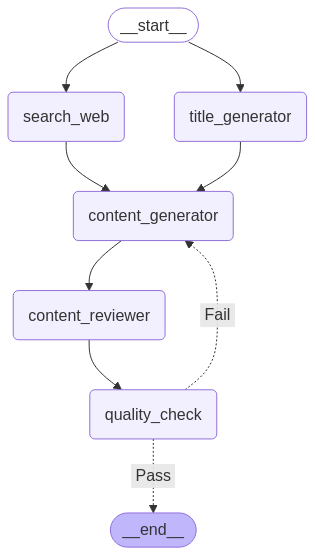

In [20]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode


builder = StateGraph(BlogState)


builder.add_node("title_generator", generate_title)
builder.add_node("search_web", search_web)
builder.add_node("content_generator", generate_content)
builder.add_node("content_reviewer", review_content)
builder.add_node("quality_check", evaluate_content)  # New evaluation node

builder.add_edge(START, "title_generator")
builder.add_edge(START, "search_web")
builder.add_edge("title_generator", "content_generator")
builder.add_edge("search_web", "content_generator")
builder.add_edge("content_generator", "content_reviewer")
builder.add_edge("content_reviewer", "quality_check")

# Add conditional edge after quality check
builder.add_conditional_edges(
    "quality_check",
    route_based_on_verdict,
    {"Pass": END, "Fail": "content_generator"}
)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [24]:
state = graph.invoke({"topic": "Langgrah Orchestrator"})
print(state["title"])
print(state["blog_content"])
print(state["reviewed_content"])
print(state["search_results"])


Mastering Langgrah Orchestrator: Unlocking Efficiency Across Industries
[HumanMessage(content="# Mastering LangGraph Orchestrator: Unlocking Efficiency Across Industries\n\nIn today's rapidly evolving technological landscape, businesses are constantly seeking ways to streamline their operations and enhance productivity. One tool that has been gaining significant traction for its ability to orchestrate complex processes efficiently is LangGraph. This article delves into the capabilities of LangGraph Orchestrator, examining how it can be leveraged to boost efficiency in various industries.\n\n## Understanding LangGraph Orchestrator\n\nLangGraph Orchestrator is a sophisticated tool designed to manage and automate workflows with a high degree of flexibility and intelligence. At its core, LangGraph employs a graph-based infrastructure, allowing for the creation of complex, multi-step workflows that can adapt to changing conditions and requirements. This system is not just about executing ta

In [23]:
graph.invoke({"topic": "Langgrah Orchestrator"})

APIConnectionError: Connection error.